  # Test of XGBoost with One vs Rest model
  
 
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint as sp_randint
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier

  ### Definition of names for plots and files

In [2]:

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v4/dfcrossmatches_prioritized_v4_withYSO_fromSimbad.csv'
features_file = '../ZTF_data/features20191119_withWISE.csv'

class_output = '../ZTF_classifications/classification_unlabelled_set_withWISE_RSCVn_periodic_20191119.csv'

#where the RF models are saved
model_name = 'stat_xgboost_onevsrest/xgboost_onevsrest_'+date

#confusion matrixes
conf_matrix_name = 'stat_xgboost_onevsrest/confusion_matrix_xgboost_onevsrest_'+date


### reading the training set files 

In [3]:
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'W2-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'W2-W3']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 
#'''



#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


164213


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'



#defining the classes included in the RF model
label_order = ['QSO-I','AGN-I', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV','RS-CVn','Periodic-Other']

#label_order = ['QSO-I','AGN-I', 'Blazar','CV/Nova', 'YSO']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

labels.head()

,class_original
oid,
ZTF18aawaqeo,CV/Nova
ZTF18acaxfpa,CV/Nova
ZTF18abxehba,CV/Nova
ZTF18aaxjjwu,CV/Nova
ZTF18abnowur,CV/Nova


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2'    
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original']]
df.drop(['Mean_1','Mean_2','class_original'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

111421
111421
111421
111421


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaact,11.0,0.139977,0.328509,1.0,0.363636,0.0,0.472415,-0.031614,2.395997,0.004443,...,322.582369,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-0.067,1.769,-999.000000,-999.000000
ZTF17aaaaahl,59.0,0.458348,0.956996,6.0,0.338983,0.0,0.032239,0.532763,3.447957,0.016959,...,229.373142,849.637793,0.983051,0.928571,0.850714,0.500000,0.166,0.659,9.668436,9.009436
ZTF17aaaaajz,0.0,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,143.078357,-999.000000,0.022727,0.701429,0.979167,-0.020,0.405,9.511996,9.106996
ZTF17aaaaaly,10.0,0.110826,0.427705,2.0,0.300000,0.0,0.201831,0.001717,0.055476,0.003597,...,4.144941,88.598544,1.000000,0.954545,0.684286,0.794833,-0.051,0.468,10.309124,9.841124
ZTF17aaaaasi,113.0,2.734854,1.000000,18.0,0.433628,0.0,0.002209,0.871545,0.226679,0.107707,...,245.809905,-660.435165,0.539823,0.534351,0.686667,0.902500,0.460,1.695,11.667063,9.972063


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_original = labels['class_original']#.values

le = LabelEncoder()

Y_original_encoded = le.fit_transform(Y_original)

X_original = df#.columns.values.tolist()



#splitting training set
X_train_original, X_test_original, y_train_original, y_test_original = model_selection.train_test_split(X_original,
Y_original_encoded, test_size=0.2, stratify=Y_original_encoded)

print(len(y_train_original))
print(len(X_train_original['n_samples_1'].values))

89136
89136


  ## Balanced XGBoost
  

In [8]:
#Training first layer of the RF model

class exgb_wrapper(imb_xgb):
    def __init__(self):
        super().__init__(num_round=100, max_depth=6, special_objective='focal', focal_gamma=1)
    
    def predict_proba(self,X):
        return self.predict_two_class(X)
exgb_classifier = exgb_wrapper()


clf = OneVsRestClassifier(exgb_classifier).fit(X_train_original.values, y_train_original)


pred = clf.predict(X_test_original.values)
pred_proba = clf.predict_proba(X_test_original.values)

print(pred_proba)



[[0.00013902 0.00040668 0.00057646 ... 0.00035762 0.00047612 0.00029079]
 [0.00052332 0.00174519 0.00571179 ... 0.00046112 0.00090933 0.00113805]
 [0.00080137 0.00042693 0.00065296 ... 0.00033834 0.00098796 0.00052289]
 ...
 [0.00078968 0.00205644 0.00574993 ... 0.0003909  0.00141199 0.00053472]
 [0.00045197 0.00040807 0.0013881  ... 0.00088094 0.00068431 0.00178451]
 [0.00073935 0.00060144 0.00981692 ... 0.00045988 0.00071456 0.00172684]]


In [9]:
print(np.amax(pred_proba[500]))
print(pred_proba[500])
print(y_train_original[500])

0.69536704
[2.7824196e-04 1.1903750e-03 6.5427489e-04 7.1334699e-04 1.8936782e-03
 1.3669418e-01 6.9536704e-01 8.4784755e-04 2.2148749e-02 3.6254770e-04
 1.3690475e-01 5.3168164e-04 5.6355313e-04 8.9257350e-04 3.1679741e-04
 4.0990906e-04 2.3066845e-04]
10


In [10]:
classes_order_proba = clf.classes_
print(classes_order_proba)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_test_original, pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, pred))

#Dumping trained model

features_list = list(X_train_original)

'''with open(model_name, 'wb') as pickle_file:
        model_dump = {
            'xgboost_model': clf,
            'features': features_list,
            'order_classes': classes_order_proba
            }
        pickle.dump(model_dump, pickle_file)'''

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Accuracy: 0.8985864931568319
Balanced accuracy: 0.5637504379452584


"with open(model_name, 'wb') as pickle_file:\n        model_dump = {\n            'xgboost_model': clf,\n            'features': features_list,\n            'order_classes': classes_order_proba\n            }\n        pickle.dump(model_dump, pickle_file)"

[[1716   70    7    1    1    0    0    0    0    4    1    0    2    0
     2    0    0]
 [ 116  303    5    0    0    0    0    0    0    1    2    0    2    0
     0    0    0]
 [  40   21  112    3    1    0    0    0    0    3    0    0    2    0
     0    0    0]
 [   1    0    4   99    1    3    0    0    0   13    2    2   27    0
     4    0    0]
 [   0    2    1    0  169    0    0    0    0   13    3    0    2    0
    28    3    0]
 [   0    0    0    1    0  125    1    2    0    0    0    0    2    0
     1    0    0]
 [   0    0    0    0    0    8    0    1    0    0    0    0    0    0
     0    0    0]
 [   0    3    0    0    0    9    1   22    1    0    0    0    2    0
     0    0    0]
 [   0    1    0    0    0    2    0    1    0    0    0    0    0    0
     0    0    0]
 [   1    0    0    2    7    0    0    0    0 4646  206    0  157    2
     8   10    0]
 [   0    0    0    1    0    0    0    0    0  777  510    3   58    1
     2    1    0]
 [   0    

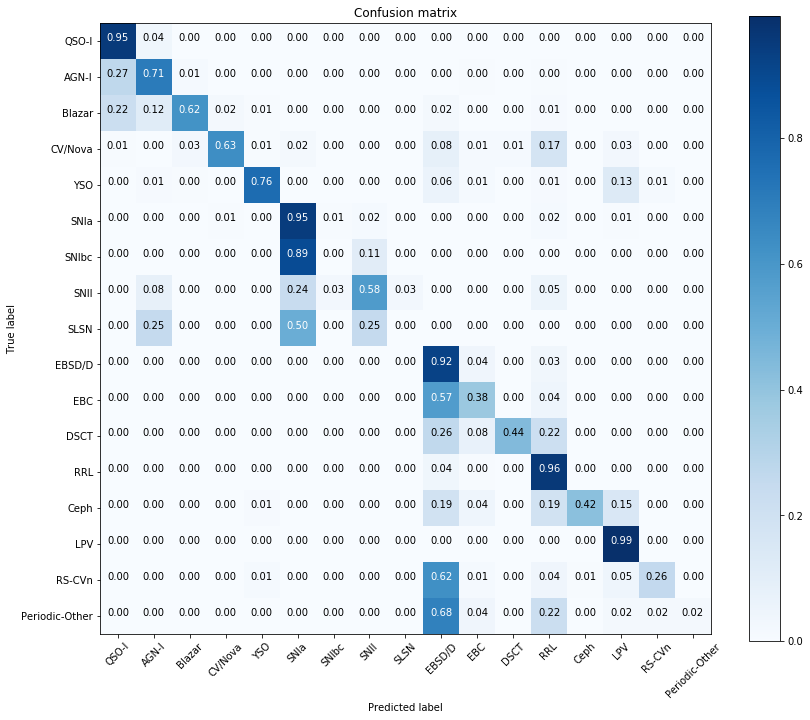

In [11]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(le.inverse_transform(y_test_original), le.inverse_transform(pred), labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,conf_matrix_name)

In [12]:
# Kaggle score

CLASSES_REDUCED_V2 = le.inverse_transform(np.arange(len(label_order)))

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(y_test_original,pred_proba))

AGN-I -0.0467604819466086
Blazar -0.07905479038462919
CV/Nova -0.07657198344959933
Ceph -0.12734209789949305
DSCT -0.10608394706950468
EBC -0.06390328968272489
EBSD/D -0.024538790478425866
LPV -0.00410567399333505
Periodic-Other -0.24115565243889303
QSO-I -0.012237127212917103
RRL -0.011812206576852237
RS-CVn -0.12731988289776972
SLSN -0.21251740175134995
SNII -0.08104484221514534
SNIa -0.019334395142162546
SNIbc -0.2107115352855009
YSO -0.052269753287820256
1.4967638517127317


  ## Classifying unlabeled data

In [13]:
#loading the data

print(df_feat.n_samples_1.size)
print(rm_nd_cols)


mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)
    
df_feat_ul_out = df_feat_ul.copy()

df_feat_ul.head()

653905
['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'paps_non_zero_1', 'paps_non_zero_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089,0.912,2.997933,2.085933
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038,0.565,5.909550,5.344550
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160,0.893,3.745013,2.852013
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014,1.623,4.135574,2.512574
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006,1.001,4.327510,3.326510


In [14]:
#predicting classes of unlabeled data

test_Y = le.inverse_transform(clf.predict(df_feat_ul.values))
test_Y_proba = clf.predict_proba(df_feat_ul.values)

In [15]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)

df_out['predicted_class'] = test_Y
df_out['predicted_class_proba'] = test_Y_proba
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(653905, 136)


ValueError: Wrong number of items passed 17, placement implies 1

In [ ]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

In [ ]:
letter_counts = Counter(test_Y_proba)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


In [ ]:

fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

In [ ]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')